<a href="https://colab.research.google.com/github/PhilipLiang1/SFSU-ENGR-sEMG-Gesture-Recognition-Project/blob/main/LDA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# upload local files to google colab
from google.colab import files
uploaded = files.upload()

Saving DevilHorns.csv to DevilHorns.csv
Saving devilhorns_test.csv to devilhorns_test.csv
Saving DevilHorns1.csv to DevilHorns1.csv
Saving HandClose.csv to HandClose.csv
Saving handclose_test.csv to handclose_test.csv
Saving HandClose1.csv to HandClose1.csv
Saving HandOpen.csv to HandOpen.csv
Saving handopen_test.csv to handopen_test.csv
Saving HandOpen1.csv to HandOpen1.csv
Saving PointIndex.csv to PointIndex.csv
Saving pointindex_test.csv to pointindex_test.csv
Saving PointIndex1.csv to PointIndex1.csv
Saving Rest.csv to Rest.csv
Saving rest_test.csv to rest_test.csv
Saving Rest1.csv to Rest1.csv
Saving test_data.csv to test_data.csv


In [ ]:
# Classification
  # imports and constants
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

from __future__ import absolute_import, division, print_function, unicode_literals

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

from numpy import mean
from numpy import std

import tensorflow as tf

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math
import io

# constants; types of flowers
#CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
#SPECIES = ['Setosa', 'Versicolor', 'Virginica']

FEATURE_NAMES = ['MAV0', 'ZC0', 'WL0', 'T0','MAV1', 'ZC1', 'WL1', 'T1', 
                 'MAV2','ZC2', 'WL2', 'T2', 'MAV3', 'ZC3', 'WL3', 'T3', 'Gestures']

GESTURES = ['Rest', 'HandClose', 'HandOpen', 'PointIndex', 'DevilHorns']




`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
# Here we use keras (a module inside of TensorFlow) to grab our flowers datasets and read them into a pandas dataframe
#train_path = tf.keras.utils.get_file(
 #   "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
#test_path = tf.keras.utils.get_file(
#    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")


# will use this to load in the data files from local pc
rest_feat_df = pd.read_csv(io.BytesIO(uploaded['Rest.csv']))
rest1_feat_df = pd.read_csv(io.BytesIO(uploaded['Rest1.csv']))
handclose_feat_df = pd.read_csv(io.BytesIO(uploaded['HandClose.csv']))
handclose1_feat_df = pd.read_csv(io.BytesIO(uploaded['HandClose1.csv']))
handopen_feat_df = pd.read_csv(io.BytesIO(uploaded['HandOpen.csv']))
handopen1_feat_df = pd.read_csv(io.BytesIO(uploaded['HandOpen1.csv']))
pointindex_feat_df = pd.read_csv(io.BytesIO(uploaded['PointIndex.csv']))
pointindex1_feat_df = pd.read_csv(io.BytesIO(uploaded['PointIndex1.csv']))
devilhorns_feat_df = pd.read_csv(io.BytesIO(uploaded['DevilHorns.csv']))
devilhorns1_feat_df = pd.read_csv(io.BytesIO(uploaded['DevilHorns1.csv']))

#df = pd.read_csv("HandFlex3.txt", sep=',', names=CSV_COLUMN_NAMES, header=0)
#df.head()
#X = df.iloc[:,1:].copy()
#print(X)
#target = df['Species'].copy()
#print(target)
#X_train, X_test, y_train, y_test = train_test_split(X,target,test_size=0.3,random_state=0)

#X = df.iloc[:,:4].copy()

# will use this to create a feature matrix that stacks all the gesture files together
feat_matrix = np.vstack([rest_feat_df.to_numpy(), rest1_feat_df.to_numpy(), 
                handclose_feat_df.to_numpy(), handclose1_feat_df.to_numpy(),
                handopen_feat_df.to_numpy(), handopen1_feat_df.to_numpy(), 
                pointindex_feat_df.to_numpy(), pointindex1_feat_df.to_numpy(),
                devilhorns_feat_df.to_numpy(), devilhorns1_feat_df.to_numpy()])

feat_matrix_df = pd.DataFrame(feat_matrix)
feat_matrix_df.columns = FEATURE_NAMES

X = feat_matrix_df.iloc[:,:16].copy()

#y = df['Species'].copy()

# will use this to get a vector of only the labels (gestures) for comparison with predicted gestures
y = feat_matrix_df['Gestures'].copy()

#print out first 5 rows to see if the format is correct
#X.head()
#y
#rest_feat_df
feat_matrix_df

,MAV0,ZC0,WL0,T0,MAV1,ZC1,WL1,T1,MAV2,ZC2,WL2,T2,MAV3,ZC3,WL3,T3,Gestures
0,1,20,1913,23,2,24,1914,21,6,14,1911,26,1,18,1914,20,0
1,2,23,1913,22,1,21,1914,24,9,24,1911,22,1,13,1914,21,0
2,2,26,1913,24,1,18,1914,24,7,21,1911,28,2,17,1914,21,0
3,1,21,1913,21,1,24,1914,24,7,25,1914,24,2,19,1914,17,0
4,1,18,1913,23,1,15,1914,21,6,24,1914,28,2,13,1914,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,4,32,1913,19,2,20,1912,21,8,22,1909,25,4,24,1911,19,4
986,2,21,1913,22,2,22,1913,23,10,23,1911,25,4,21,1912,22,4
987,2,25,1913,22,2,18,1913,24,11,22,1912,26,4,22,1912,22,4
988,2,25,1913,23,2,20,1912,21,8,24,1909,25,4,20,1912,22,4


In [ ]:
# from LDA tutorial
  #define model
model = LDA() 
  #define model evaluation method (k-fold cross validation, repeat 10 times with shuffling data)
cv = KFold(n_splits=200, shuffle=False, random_state=None) #no shuffling version of 200-fold cross-validation
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
  #evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  #summarize result: average accuracy across the 10 repeats of 50-fold cross-validation
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Mean Accuracy: 0.820 (0.266)


In [ ]:
# from LDA tutorial
# make a prediction with the lda model
  #fit model
model.fit(X, y)

  #define new data
#setosa = [5.1, 3.3, 1.7, 0.5] #expected class: 0
#versicolor = [5.9, 3.0, 4.2, 1.5] #expected class: 1
#virginica = [6.9, 3.1, 5.4, 2.1] #expected class: 2

rest = X.iloc[55,:].copy() #expected class: 0; predicted 0
#rest = X.iloc[67,:].copy() #expected class: 0; predicted 4

handclose = X.iloc[250,:].copy() #expected class: 1; predicted 1

#handopen = X.iloc[467,:].copy() #expected class: 2; predicted 3
handopen = X.iloc[488,:].copy() #expected class: 2; predicted 2

pointindex = X.iloc[675,:].copy() #expected class: 3; predicted 3

devilhorns = X.iloc[867,:].copy() #expected class: 4; predicted 2
#devilhorns = X.iloc[834,:].copy() #expected class: 4; predicted 4

  #expected classes
y_exp = y[55] 
#y_exp = y[67] 

#y_exp = y[250]

#y_exp = y[467]
#y_exp = y[488]

#y_exp = y[675] 

#y_exp = y[867] 
#y_exp = y[834]

  #make a prediction
prediction = model.predict([rest.to_numpy()]) 
#prediction = model.predict([handclose.to_numpy()]) 
#prediction = model.predict([handopen.to_numpy()]) 
#prediction = model.predict([pointindex.to_numpy()]) 
#prediction = model.predict([devilhorns.to_numpy()]) 

  #summarize prediction
print('Expected Class: %d' % y_exp)
print('Predicted Class: %d' % prediction)


Expected Class: 0
Predicted Class: 0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
#use test set to evaluate accuracy of model
test_df = pd.read_csv(io.BytesIO(uploaded['test_data.csv']))
test_df.columns = FEATURE_NAMES
x_data_df = test_df.iloc[:,:16].copy()
x_data = x_data_df.to_numpy()
#x_data_df.head()

y_data_df = test_df['Gestures'].copy()
y_data = y_data_df.to_numpy()

#print('%d' % model.predict([x_data[2]]))
#for printing model's accuracy on test set
acc = 0
pred_array = []
#y_data_df.head()
for i in range(0,len(x_data)): 
   pred = '%d' % model.predict([x_data[i]])
   pred_array.append(pred)
   if int(pred_array[i]) == y_data[i]:
     acc += 1

#int(pred_array[0])
print('Accuracy on Test Set: %d%%' % acc)


Accuracy on Test Set: 82%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnal

In [ ]:
#output confusion matrix for test data
y_pred = model.predict(x_data_df)
cf_matrix = confusion_matrix(y_data_df,y_pred)
print(cf_matrix)

[[19  0  0  0  0]
 [ 0 18  0  2  0]
 [ 0  0 20  0  0]
 [ 0  0  1  9 10]
 [ 0  0  0  4 16]]


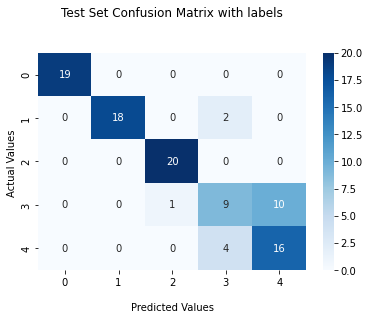

In [ ]:
#convert cf_matrix to heat_map for better visual
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Test Set Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
#for loading test data to check model's prediction
rest_test_df = pd.read_csv(io.BytesIO(uploaded['rest_test.csv']))
handclose_test_df = pd.read_csv(io.BytesIO(uploaded['handclose_test.csv']))
handopen_test_df = pd.read_csv(io.BytesIO(uploaded['handopen_test.csv']))
pointindex_test_df = pd.read_csv(io.BytesIO(uploaded['pointindex_test.csv']))
devilhorns_test_df = pd.read_csv(io.BytesIO(uploaded['devilhorns_test.csv']))

rest_test_df.columns = FEATURE_NAMES
handclose_test_df.columns = FEATURE_NAMES
handopen_test_df.columns = FEATURE_NAMES
pointindex_test_df.columns = FEATURE_NAMES
devilhorns_test_df.columns = FEATURE_NAMES

#store features of each gesture from respective files
rx_data_df = rest_test_df.iloc[:,:16].copy()
rx_data = rx_data_df.to_numpy()

hcx_data_df = handclose_test_df.iloc[:,:16].copy()
hcx_data = hcx_data_df.to_numpy()

hox_data_df = handopen_test_df.iloc[:,:16].copy()
hox_data = hox_data_df.to_numpy()

pix_data_df = pointindex_test_df.iloc[:,:16].copy()
pix_data = pix_data_df.to_numpy()

dhx_data_df = devilhorns_test_df.iloc[:,:16].copy()
dhx_data = dhx_data_df.to_numpy()

#store gesture labels from respective files
ry_data_df = rest_test_df['Gestures'].copy()
ry_data = ry_data_df.to_numpy()

hcy_data_df = handclose_test_df['Gestures'].copy()
hcy_data = hcy_data_df.to_numpy()

hoy_data_df = handopen_test_df['Gestures'].copy()
hoy_data = hoy_data_df.to_numpy()

piy_data_df = pointindex_test_df['Gestures'].copy()
piy_data = piy_data_df.to_numpy()

dhy_data_df = devilhorns_test_df['Gestures'].copy()
dhy_data = dhy_data_df.to_numpy()


In [ ]:
#for printing out mostly likely prediction
r = 0
hc = 0
ho = 0
pi = 0
dh = 0

#indicate which gesture you are testing for
feature_test_data = hox_data
#label_test_data = ry_data

gesture_array = []
for i in range(0,len(feature_test_data)): 
   pred = '%d' % model.predict([feature_test_data[i]])
   gesture_array.append(pred)
   if int(gesture_array[i]) == 0:
     r += 1
   if int(gesture_array[i]) == 1:
     hc += 1
   if int(gesture_array[i]) == 2:
     ho += 1
   if int(gesture_array[i]) == 3:
     pi += 1
   if int(gesture_array[i]) == 4:
     dh += 1

amount = [r,hc,ho,pi,dh]
#int(pred_array[0])
print(amount)
print('Predicted gesture: %d' % np.argmax(amount))

[0, 0, 19, 0, 0]
Predicted gesture: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnal

In [ ]:
#use pip install pySerial
!pip install PySerial

import serial
import serial.tools.list_ports

import bokeh.layouts
import bokeh.models
import bokeh.io

In [ ]:
ports = serial.tools.list_ports.comports()

# Take a look
ports

[]

In [ ]:
#stream in data from serial port and convert it to a numpy array

port = 'COM3'
baud = 115200
byte = 8
time = 2
stop = serial.STOPBITS_ONE

serialPort = serial.Serial(port = port, baudrate = baud, bytesize = byte, timeout = time, stopbits = stop)

serialString = ""  # Used to hold data coming over UART

while(1):

    # Wait until there is data waiting in the serial buffer
    if(serialPort.in_waiting > 0):
        # Open the serial port; prevents other processes from accessing it 
        serialPort.open()

        # Read data out of the buffer until a carriage return / new line is found
        serialString = serialPort.readline()

        # Print the contents of the serial data
        print(serialString.decode('Ascii'))

        serialPort.write('%d' % prediction)

#feed each array into lda model to classify gesture

#record those gestures in a numpy array

#after 10? sets of features classified, output the gesture that occurs the most to bluetooth UART?

SerialException: ignored